In [20]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from statistics import median 
from sklearn.model_selection import train_test_split

In [2]:
# Import datasource
listings = pd.read_csv('C:/Users/ilove/Documents/listings_Nov.csv')
calendar = pd.read_csv('C:/Users/ilove/Documents/calendar_Nov.csv')
listings_dec = pd.read_csv('C:/Users/ilove/Documents/listings_Dec.csv')
calendar_dec = pd.read_csv('C:/Users/ilove/Documents/calendar_Dec.csv')

In [3]:
# Explore listings data
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19863 entries, 0 to 19862
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            19863 non-null  int64  
 1   listing_url                                   19863 non-null  object 
 2   scrape_id                                     19863 non-null  int64  
 3   last_scraped                                  19863 non-null  object 
 4   name                                          19861 non-null  object 
 5   description                                   19058 non-null  object 
 6   neighborhood_overview                         12674 non-null  object 
 7   picture_url                                   19862 non-null  object 
 8   host_id                                       19863 non-null  int64  
 9   host_url                                      19863 non-null 

In [3]:
# Remove columns with null value only
listings.columns[listings.isnull().all()]
listings_drop_null = listings.dropna(how='all')

<AxesSubplot:title={'center':'Total number of hosts from 2010 to 2020'}, xlabel='host_since_year'>

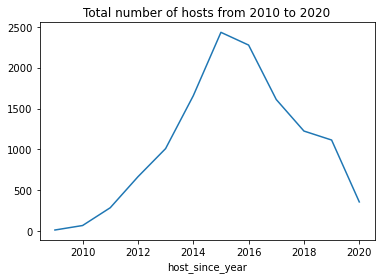

In [5]:
# Plot number of registed hosts per year 
listings['host_since_year'] = pd.DatetimeIndex(listings['host_since']).year
listings[['host_since_year','host_id']].groupby(['host_since_year']).host_id.nunique().plot(title = "Total number of hosts from 2010 to 2020")

<AxesSubplot:title={'center':'Rental types on Airbnb in Melbourne'}>

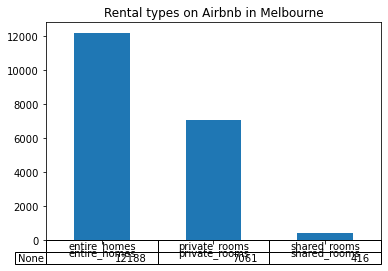

In [6]:
# Plot total number of property by rental mode 
host = listings[['host_id','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms']].groupby(['host_id']).max()
host = host.rename(columns = {'calculated_host_listings_count_entire_homes':'entire_homes','calculated_host_listings_count_private_rooms':'private_rooms','calculated_host_listings_count_shared_rooms':'shared_rooms'})
host[['entire_homes','private_rooms','shared_rooms']].sum().plot(kind = 'bar', rot=0, title = "Rental types on Airbnb in Melbourne",table=True)


In [7]:
# Explore calendar data
print(calendar.head())
print(calendar.info())
Max_date = calendar.date.max()
Min_date = calendar.date.min()
print(Max_date,Min_date)

   listing_id        date available    price adjusted_price  minimum_nights  \
0      466732  2020-11-05         t  $337.00        $337.00               3   
1      466732  2020-11-06         f  $337.00        $337.00               3   
2      466732  2020-11-07         f  $337.00        $337.00               3   
3      466732  2020-11-08         t  $337.00        $337.00               3   
4      466732  2020-11-09         t  $337.00        $337.00               3   

   maximum_nights  
0            1125  
1            1125  
2              28  
3              28  
4              28  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7249995 entries, 0 to 7249994
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   listing_id      int64 
 1   date            object
 2   available       object
 3   price           object
 4   adjusted_price  object
 5   minimum_nights  int64 
 6   maximum_nights  int64 
dtypes: int64(3), object(4)
memory usage:

In [4]:
# examine where the null values are located
calendar.isnull().sum()
# drop null values in calendar dataset because price and adjusted price are the only two columns with null values, and the 
# adjusted price is null when price is null. Also, it doesn't make sense to rent out properties for free.
calendar_clean = calendar.dropna()
# create a new column, "yr-mth" 
calendar_clean.loc[:,'yr-mth'] = pd.to_datetime(calendar_clean['date']).dt.strftime('%Y-%m')

C:\Users\ilove\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\ilove\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [5]:
# Show the number of unique listings by year month 
listing_by_yearmonth = calendar_clean[['listing_id','yr-mth']].groupby('yr-mth').nunique().rename(columns ={'listing_id':'count'})
listing_by_yearmonth.unstack('yr-mth')

       yr-mth 
count  2020-11    19863
       2020-12    19863
       2021-01    19863
       2021-02    19863
       2021-03    19863
       2021-04    19863
       2021-05    19863
       2021-06    19862
       2021-07    19862
       2021-08    19862
       2021-09    19862
       2021-10    19862
       2021-11    19862
dtype: int64

In [6]:
# Transfer the data type of price from object to numeric
calendar_clean.loc[:,'price'] = [x.strip('$') for x in calendar_clean['price']]
calendar_clean.loc[:,'adjusted_price'] = [x.strip('$') for x in calendar_clean['adjusted_price']]                                              
calendar_clean.loc[:,'price'] = calendar_clean['price'].str.replace(',','')
calendar_clean.loc[:,'adjusted_price'] = calendar_clean['adjusted_price'].str.replace(',','')                                              
calendar_clean.loc[:,'price'] = pd.to_numeric(calendar_clean['price'])
calendar_clean.loc[:,'adjusted_price'] = pd.to_numeric(calendar_clean['adjusted_price'])

In [7]:
# Create a new column to show the difference between adjusted price and price
calendar_clean.loc[:,'price_diff'] = calendar_clean['adjusted_price'] - calendar_clean['price']

In [8]:
# Subset calendar_clean
sub_calendar_clean = calendar_clean[['listing_id','yr-mth','price','price_diff','adjusted_price','available','date']]

In [9]:
# Merge listings to sub_calendar_clean
listings_date = pd.merge(listings_drop_null, sub_calendar_clean, left_on=['id'],right_on=['listing_id'])

In [14]:
# Calculate rental rate by neighbourhood
occupy_times = listings_date[['available','neighbourhood','id']].groupby(['neighbourhood','available']).count()
reset_occ = occupy_times.reset_index('available')
reset_occ['total'] = occupy_times.groupby(['neighbourhood']).sum()
reset_occ['rate'] = reset_occ['id']/reset_occ['total']
reset_occ['uni_id_count'] = listings_date[['id','neighbourhood']].groupby('neighbourhood').nunique()
ava_f = reset_occ[(reset_occ['uni_id_count']>=10) & (reset_occ['available']=='f')].drop('available',axis=1).sort_values(['rate'],ascending=False)
ava_t = reset_occ[(reset_occ['uni_id_count']>=10) & (reset_occ['available']=='t')].drop('available',axis=1).sort_values('rate',ascending=False)
price = listings_date[['available','neighbourhood','price_y']].groupby(['neighbourhood','available']).median()
reset_price = price.reset_index(1)
ava_f['median_p'] = reset_price[reset_price['available']=='f'].drop('available',axis=1)
ava_f = ava_f.rename(columns = {'id':'f_count'})
print(ava_f.head(10))
print(ava_t.head(10))



                                     f_count  total      rate  uni_id_count  \
neighbourhood                                                                 
Caulfield, Victoria, Australia          2896   3650  0.793425            10   
Pakenham, Victoria, Australia           5160   6570  0.785388            18   
Carlton North, Victoria, Australia     16767  21535  0.778593            59   
Cremorne, Victoria, Australia           5926   7665  0.773125            21   
Bonbeach, Victoria, Australia           3041   4015  0.757410            11   
Carnegie, Victoria, Australia           9048  12045  0.751183            33   
Box Hill North, Victoria, Australia     4737   6570  0.721005            18   
Brighton East, Victoria, Australia      6807   9490  0.717281            26   
Northcote, Victoria, Australia         43726  61320  0.713079           168   
Windsor, Victoria, Australia           22890  32120  0.712640            88   

                                     median_p  
nei

C:\Users\ilove\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-17-2d8fee6ea05e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occupy_property['month'] = occupy_property['date'].dt.to_period('M')


array([<AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>],
      dtype=object)

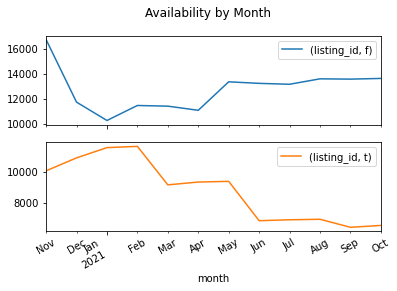

In [17]:
# Plot the number of available and unavailable properties by month
occupy_property = listings_date[['listing_id','property_type','price_y','available','date']]
occupy_property.loc[:,'date'] = pd.to_datetime(occupy_property['date'])
occupy_property['month'] = occupy_property['date'].dt.to_period('M')
occupy_property_filtered = occupy_property[occupy_property['date']<'2021-11-01']
occupy_property_filtered = occupy_property_filtered[['listing_id','available','month']].groupby(['available','month']).nunique()
occupy_property_filtered.unstack('available').plot.line(subplots=True, title="Availability by Month")

In [16]:
# Calculate the total number of rentals and median price by property type
occupy_property[occupy_property['available']=='t'].drop('date',axis=1).groupby(['property_type','price_y','month']).count()
op_filtered = occupy_property[occupy_property['available']=='t']
top10 = op_filtered[['listing_id','property_type']].groupby('property_type').count().sort_values(['listing_id'],ascending=False)
top10_col = top10.index
ot = op_filtered.set_index('property_type').loc[top10_col,['price_y']]
ot_avg_price = ot.reset_index().groupby('property_type').median()
result = top10.join(ot_avg_price)
result = result.rename(columns={'listing_id':'rental_counts','price_y':'median_price'}).sort_values('median_price',ascending=False)
result_count = result.sort_values(['rental_counts'],ascending=False)
print(result.head(10))
print(result_count.head(10))

                           rental_counts  median_price
property_type                                         
Private room in chalet               181        1000.0
Castle                               763         407.0
Private room                        1171         385.0
Room in nature lodge                1052         323.0
Entire villa                       17723         320.0
Entire bed and breakfast            4463         300.0
Boat                                1335         299.0
Entire home/apt                      694         258.0
Barn                                 465         250.0
Room in bed and breakfast           6036         250.0
                           rental_counts  median_price
property_type                                         
Entire apartment                 1106253         145.0
Private room in house             478275          55.0
Entire house                      327684         250.0
Private room in apartment         221447          70.0
Entire ser

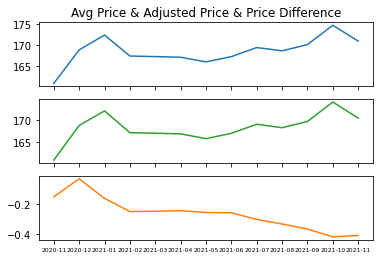

In [8]:
# Plot prices by by month
price_trend = calendar_clean[['yr-mth','price','price_diff','adjusted_price']].groupby('yr-mth').mean()
fig, axs = plt.subplots(3,sharex='all')
axs[0].set_title('Avg Price & Adjusted Price & Price Difference')
axs[0].plot(price_trend.index.values,price_trend['price'])
axs[1].plot(price_trend.index.values,price_trend['adjusted_price'],'tab:green')
axs[2].plot(price_trend.index.values,price_trend['price_diff'],'tab:orange')
plt.xticks(fontsize=6)
plt.show()

In [10]:
# Subset listings_date to keep only review scores and accommodates 
sub_listings = listings_date[['id','accommodates','review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location','review_scores_value', 'price_y','available']]
sub_listings.columns[sub_listings.notnull().all()]

Index(['id', 'accommodates', 'price_y', 'available'], dtype='object')

In [31]:
# Examine null values
sub_listings.isnull().sum()

id                             0
accommodates                   0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
price_y                        0
available                      0
dtype: int64

In [11]:
# Replace null values by column median
# Replace null values by column mean is an alternative way but the performance is extremely slow when fillna by mean so median is used. 
sub_listings[['review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']] = sub_listings[['review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']].fillna(sub_listings.median())


C:\Users\ilove\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [12]:
# Prepare to run logistic regression model
logreg = linear_model.LogisticRegression()

In [13]:
# Create a copy of the dataframe
cat_df_copy = sub_listings.copy()
# Pull a list of the column names of the categorical variables
cat_cols_lst = cat_df_copy[['available']]
# Create a function to create dummy variables for variables in object data type
def create_dummy_df(table, cat_cols, dummy_na):
    for col in  cat_cols:
        try:
            table = pd.concat([table.drop(col, axis=1), pd.get_dummies(table[col], prefix=col, prefix_sep='_', drop_first=False, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return table

In [50]:
# Assign parameters
table = cat_df_copy
listings_dummy = create_dummy_df(table, cat_cols_lst, False)
target = listings_dummy['available_f']
vals = listings_dummy.drop(['available_t','id','available_f'],axis=1)
vals = vals.columns

In [15]:
# Create a function to fit logistic regression model and calculate its auc value
def auc_fn(variables, target, df):
    X = df[variables]
    y = df[target]
    logreg = linear_model.LogisticRegression()
    logreg.fit(X,y.values.ravel())
    predictions = logreg.predict_proba(X)[:,1]
    auc = roc_auc_score(y,predictions)
    return(auc)
auc = auc_fn(vals, ['available_f'], listings_dummy)
print(round(auc,4))

0.5729


In [16]:
# Create a function to keep important variables by comparing auc values
def next_best(current_variable,candidate_variable,target,basetable):
    best_auc = -1
    best_variable = None
    for v in candidate_variable:
        auc_v = auc_fn(current_variables + [v],target,basetable)
        if auc_v >= best_auc:
            best_auc = auc_v
            best_variable = v
    return best_variable

In [73]:
# Split the model into train and test sets
X = listings_dummy.drop(['available_t','id','available_f'],axis=1)
y = listings_dummy['available_f']
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.3,stratify=y)
# Create the final train and test basetables
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Check whether train and test have same percentage targets
print(round(sum(train['available_f'])/len(train), 2))
print(round(sum(test['available_f'])/len(test), 2))

0.6
0.6


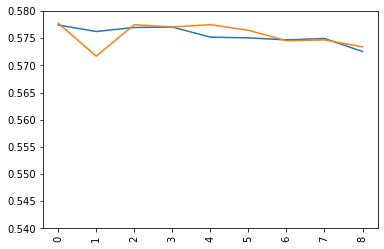

In [91]:
# Store auc values generated from train and test sets
train_df = pd.concat([y_train,X_train],axis=1)
test_df = pd.concat([y_test,X_test],axis=1)
auc_values_train = []
auc_values_test = []
variables_evaluate = []
for v in vals2:
# Add the variable
    variables_evaluate.append(v)
    
    # Calculate the train and test AUC of this set of variables
    auc_train = auc_fn(variables_evaluate,'available_f', train_df)
    auc_test = auc_fn(variables_evaluate, 'available_f', test_df)
    # Append the values to the lists
    auc_values_train.append(auc_train)
    auc_values_test.append(auc_test)

# Plot auc curve from train and test sets to find out the cut off point
# The model is underfitting so it is not suitable to use in prediction
# From the plot, 3 variables should be included in the model
x = np.array(range(0,len(auc_values_train)))
y_train = np.array(auc_values_train)
y_test = np.array(auc_values_test)
plt.xticks(x, rotation = 90)
plt.plot(x,y_train)
plt.plot(x,y_test)
plt.ylim((0.56, 0.58))
plt.show()

In [92]:
# Show the top 3 most important variables using for loop and functions created above
current_variables = []
target = ['available_f']
max_number_variables = 3
number_iterations = min(max_number_variables, len(vals))
for i in range(0,number_iterations):    
    next_variable = next_best(current_variables,vals,target,listings_dummy)    
    current_variables = current_variables + [next_variable]    
    vals = vals.drop(next_variable)
    print("Variable added in step " + str(i+1)  + " is " + next_variable + ".")
print(current_variables)

Variable added in step 1 is price_y.
Variable added in step 2 is review_scores_value.
Variable added in step 3 is review_scores_cleanliness.
['price_y', 'review_scores_value', 'review_scores_cleanliness']


In [93]:
# Display coefficients and intercept of au3 because it has the highest auc value
new_x = listings_dummy[['price_y', 'review_scores_value', 'review_scores_cleanliness']]
logreg.fit(new_x,listings_dummy['available_f'])
coef = logreg.coef_
intercept = logreg.intercept_
print(coef)
print(intercept)
model_df = pd.DataFrame( np.array([[-2.04975609e-04,  2.21994408e-01, -1.77701089e-01,0.00406632]]) ,columns = ['price_y', 'review_scores_value', 'review_scores_cleanliness','intercept'])
print(model_df)

[[-2.04975609e-04  2.21994408e-01 -1.77701089e-01]]
[0.00406632]
    price_y  review_scores_value  review_scores_cleanliness  intercept
0 -0.000205             0.221994                  -0.177701   0.004066
